In [1]:
import pandas as pd
import re
import numpy as np
import string
import pymorphy3
import stop_words

In [2]:
df = pd.read_json("corpus_raw.json")

In [3]:
len(df)

12098

In [4]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])

In [5]:
corpus = df.text.to_list()
texts = df.text.to_list()
targets = df.category.to_list()
len(corpus), len(texts), len(targets)

(12098, 12098, 12098)

In [6]:
corpus[42]

'С января страховая пенсия по старости выросла на 7,3%, в среднем до 24 059 руб., сообщил депутат Госдумы Никита Чаплин («Единая Россия»). С февраля эта сумма вырастет.«После перерасчета эта сумма увеличится еще на 2,2%, то есть выплата составит около 25 тыс. руб.»,— рассказал «Прайму» господин Чаплин.В декабре глава Минтруда сообщил, что в феврале пенсии будут дополнительно проиндексированы до уровня фактической инфляции. На этой неделе президент Владимир Путин заявил, что страховые и военные пенсии, социальные выплаты и пособия будут проиндексированы на 9,5%.Подробности — в материале «Ъ» «Инфляция ждет индексации пенсий».'

Произведём удаление:  
- ссылок
- пробелов

In [7]:
corpus = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', u'', doc) for doc in corpus]
corpus = [re.sub(' +' , ' ', doc) for doc in corpus]
corpus = np.asarray([doc.strip().strip('\t').replace('\n', u'') for doc in corpus])

In [8]:
corpus[42]

np.str_('С января страховая пенсия по старости выросла на 7,3%, в среднем до 24 059 руб., сообщил депутат Госдумы Никита Чаплин («Единая Россия»). С февраля эта сумма вырастет.«После перерасчета эта сумма увеличится еще на 2,2%, то есть выплата составит около 25 тыс. руб.»,— рассказал «Прайму» господин Чаплин.В декабре глава Минтруда сообщил, что в феврале пенсии будут дополнительно проиндексированы до уровня фактической инфляции. На этой неделе президент Владимир Путин заявил, что страховые и военные пенсии, социальные выплаты и пособия будут проиндексированы на 9,5%.Подробности — в материале «Ъ» «Инфляция ждет индексации пенсий».')

Убираем лишние символы

In [9]:
regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
regex_dig = re.compile('[%s]' % re.escape(string.digits))
regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_struct = re.compile('[%s]' % string.printable + string.whitespace)
emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+")

In [10]:
corpus = [regex_punct.sub('', doc) for doc in corpus]
corpus = [regex_dig.sub('', doc) for doc in corpus]
corpus = [regex_symb.sub(' ', doc) for doc in corpus]
corpus = [regex_struct.sub('', doc) for doc in corpus]
corpus = [re.sub(' +' , ' ', doc.strip()) for doc in corpus]
corpus = [emoji_pattern.sub('', doc) for doc in corpus]
len(corpus)

12098

In [11]:
corpus[42]

'С января страховая пенсия по старости выросла на в среднем до руб сообщил депутат Госдумы Никита Чаплин Единая Россия С февраля эта сумма вырастет После перерасчета эта сумма увеличится еще на то есть выплата составит около тыс руб рассказал Прайму господин ЧаплинВ декабре глава Минтруда сообщил что в феврале пенсии будут дополнительно проиндексированы до уровня фактической инфляции На этой неделе президент Владимир Путин заявил что страховые и военные пенсии социальные выплаты и пособия будут проиндексированы на Подробности в материале Ъ Инфляция ждет индексации пенсий'

In [12]:
indecies = np.asarray([i for i, doc in enumerate(corpus) if len(doc) > 0 ])
targets = np.asarray([target for doc, target in zip(corpus, targets ) if len(doc) >0])
texts = np.asarray([txt for doc, txt in zip(corpus, texts) if len(doc) > 0])
print(len(texts))
corpus = np.asarray([doc for doc in corpus if len(doc) > 0])
print(len(corpus))

12093
12093


In [13]:
len(targets)

12093

In [14]:
corpus = [doc.lower() for doc in corpus]

In [15]:
corpus[42]

'с января страховая пенсия по старости выросла на в среднем до руб сообщил депутат госдумы никита чаплин единая россия с февраля эта сумма вырастет после перерасчета эта сумма увеличится еще на то есть выплата составит около тыс руб рассказал прайму господин чаплинв декабре глава минтруда сообщил что в феврале пенсии будут дополнительно проиндексированы до уровня фактической инфляции на этой неделе президент владимир путин заявил что страховые и военные пенсии социальные выплаты и пособия будут проиндексированы на подробности в материале ъ инфляция ждет индексации пенсий'

Произведём токенизаци и удаление стоп слов

In [16]:
morph = pymorphy3.MorphAnalyzer()

In [17]:
corpus_tokens = []
inds_to_drop = []

for i, sentence in enumerate(corpus[:]):
    tmp_tokens = []
    sp = sentence.split()
    for word in sp:
        if word not in stop_words.get_stop_words('ru'):
            if morph.word_is_known(word):
                tmp_tokens.append(word)
    if len(tmp_tokens) > 0:
        corpus_tokens.append(tmp_tokens)
    else:
        inds_to_drop.append(i)
#     break
        
print(len(corpus_tokens), len(texts))

12093 12093


In [18]:
inds_to_drop

[]

In [19]:
df.text[42]

'С января страховая пенсия по старости выросла на 7,3%, в среднем до 24 059 руб., сообщил депутат Госдумы Никита Чаплин («Единая Россия»). С февраля эта сумма вырастет.«После перерасчета эта сумма увеличится еще на 2,2%, то есть выплата составит около 25 тыс. руб.»,— рассказал «Прайму» господин Чаплин.В декабре глава Минтруда сообщил, что в феврале пенсии будут дополнительно проиндексированы до уровня фактической инфляции. На этой неделе президент Владимир Путин заявил, что страховые и военные пенсии, социальные выплаты и пособия будут проиндексированы на 9,5%.Подробности — в материале «Ъ» «Инфляция ждет индексации пенсий».'

In [20]:
corpus_tokens[42]

['января',
 'страховая',
 'пенсия',
 'старости',
 'выросла',
 'среднем',
 'руб',
 'сообщил',
 'депутат',
 'госдумы',
 'никита',
 'чаплин',
 'единая',
 'россия',
 'февраля',
 'сумма',
 'вырастет',
 'перерасчета',
 'сумма',
 'увеличится',
 'выплата',
 'составит',
 'тыс',
 'руб',
 'рассказал',
 'господин',
 'декабре',
 'глава',
 'минтруда',
 'сообщил',
 'феврале',
 'пенсии',
 'дополнительно',
 'проиндексированы',
 'уровня',
 'фактической',
 'инфляции',
 'неделе',
 'президент',
 'владимир',
 'путин',
 'заявил',
 'страховые',
 'военные',
 'пенсии',
 'социальные',
 'выплаты',
 'пособия',
 'проиндексированы',
 'подробности',
 'материале',
 'инфляция',
 'ждет',
 'индексации',
 'пенсий']

Воспользуемся лемматизацией

In [21]:
corpus_tokens_lemm = []
for i, tokens in enumerate(corpus_tokens[:]):
    tmp = [morph.parse(word)[0].normal_form for word in tokens]
    corpus_tokens_lemm.append(tmp)
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000


In [22]:
corpus_tokens[42]

['января',
 'страховая',
 'пенсия',
 'старости',
 'выросла',
 'среднем',
 'руб',
 'сообщил',
 'депутат',
 'госдумы',
 'никита',
 'чаплин',
 'единая',
 'россия',
 'февраля',
 'сумма',
 'вырастет',
 'перерасчета',
 'сумма',
 'увеличится',
 'выплата',
 'составит',
 'тыс',
 'руб',
 'рассказал',
 'господин',
 'декабре',
 'глава',
 'минтруда',
 'сообщил',
 'феврале',
 'пенсии',
 'дополнительно',
 'проиндексированы',
 'уровня',
 'фактической',
 'инфляции',
 'неделе',
 'президент',
 'владимир',
 'путин',
 'заявил',
 'страховые',
 'военные',
 'пенсии',
 'социальные',
 'выплаты',
 'пособия',
 'проиндексированы',
 'подробности',
 'материале',
 'инфляция',
 'ждет',
 'индексации',
 'пенсий']

In [23]:
corpus_tokens_lemm[42]

['январь',
 'страховой',
 'пенсия',
 'старость',
 'вырасти',
 'среднее',
 'руб',
 'сообщить',
 'депутат',
 'госдума',
 'никита',
 'чаплин',
 'единый',
 'россия',
 'февраль',
 'сумма',
 'вырасти',
 'перерасчёт',
 'сумма',
 'увеличиться',
 'выплата',
 'составить',
 'тыс',
 'руб',
 'рассказать',
 'господин',
 'декабрь',
 'глава',
 'минтруд',
 'сообщить',
 'февраль',
 'пенсия',
 'дополнительно',
 'проиндексировать',
 'уровень',
 'фактический',
 'инфляция',
 'неделя',
 'президент',
 'владимир',
 'путин',
 'заявить',
 'страховой',
 'военный',
 'пенсия',
 'социальный',
 'выплата',
 'пособие',
 'проиндексировать',
 'подробность',
 'материал',
 'инфляция',
 'ждать',
 'индексация',
 'пенсия']

Попробуем проанализировать полученные токены.   
Для начала соберём все токены в одном списке, потом подсчитаем общее количество каждого.  
Затем выведем наиболее частоповторяющиеся из них 

In [24]:
all_tokens = [token for tokens in corpus_tokens for token in tokens]

In [25]:
tokensdf = pd.DataFrame(all_tokens, columns=["word"])

In [26]:
tokensdf.groupby("word").size().sort_values(ascending=False).head(100).to_csv("tokens.csv")

In [27]:
df.category.unique()

array(['Экономика', 'Общество', 'Потребительский рынок',
       'Телекоммуникации', 'Бизнес', 'Политика', 'Происшествия',
       'Культура ', 'Спорт', 'Финансы', 'Мир', 'Hi-Tech'], dtype=object)

Если посмотреть на список слов, сразу становится понятно, что он связан с новостями, причём в основном с экономикой, политикой и бизнесом.  

In [28]:
money_theme_mask = (
    (df["category"] == 'Экономика') |
    (df["category"] == 'Потребительский рынок') | 
    (df['category'] == 'Бизнес') | 
    (df['category'] == 'Финансы')
)

politic_theme_mask = (
    (df["category"] == 'Общество') |
    (df["category"] == 'Политика') |
    (df["category"] == 'Мир')
)

culture_theme_mask = (
    (df["category"] == 'Культура') |
    (df["category"] == 'Спорт') |
    (df["category"] == 'Телекоммуникации')
)

In [29]:
money_theme_texts = df[money_theme_mask]
politic_theme_texts = df[politic_theme_mask]
culture_theme_texts = df[culture_theme_mask]

In [30]:
money_theme_tokens = pd.DataFrame([ token  for ind in df[money_theme_mask].index for token in corpus_tokens[ind]], columns=["token"])
money_theme_tokens_count = money_theme_tokens.groupby("token").size().sort_values(ascending=False)
money_theme_tokens_count.to_csv("tokens_money_theme.csv")
money_theme_tokens_count.head(10), money_theme_tokens_count.sum(), len(money_theme_tokens_count)

print("Топ10:\n", money_theme_tokens_count.head(10))
print("Общее количество токенов:\n", money_theme_tokens_count.sum())
print("Количество уникальных токенов:\n", len(money_theme_tokens_count))

Топ10:
 token
руб         6366
тыс         3982
млрд        3888
россии      3536
млн         3342
компании    3139
рост        2034
рынке       1962
рынка       1931
словам      1748
dtype: int64
Общее количество токенов:
 771713
Количество уникальных токенов:
 61250


In [31]:
money_theme_tokens_count.mean(), money_theme_tokens_count.var()

(np.float64(12.599395918367346), np.float64(4353.968544427647))

In [32]:
politic_theme_tokens = pd.DataFrame([ token  for ind in df[politic_theme_mask].index for token in corpus_tokens[ind]], columns=["token"])
politic_theme_tokens_count = politic_theme_tokens.groupby("token").size().sort_values(ascending=False)
politic_theme_tokens_count.to_csv("tokens_politic_theme.csv")

print("Топ10:\n", politic_theme_tokens_count.head(10))
print("Общее количество токенов:\n", politic_theme_tokens_count.sum())
print("Количество уникальных токенов:\n", len(politic_theme_tokens_count))

Топ10:
 token
россии        2517
сша           1839
господин      1832
января        1615
тыс           1560
президент     1544
президента    1315
владимир      1250
путин         1152
рф            1101
dtype: int64
Общее количество токенов:
 497788
Количество уникальных токенов:
 64664


In [33]:
politic_theme_tokens_count.mean(), politic_theme_tokens_count.var()

(np.float64(7.698070023506124), np.float64(1110.902326201057))

In [34]:
culture_theme_tokens = pd.DataFrame([ token  for ind in df[culture_theme_mask].index for token in corpus_tokens[ind]], columns=["token"])
culture_theme_tokens_count = culture_theme_tokens.groupby("token").size().sort_values(ascending=False)
culture_theme_tokens_count.to_csv("tokens_culture_theme.csv")
culture_theme_tokens_count.head(10), culture_theme_tokens_count.sum(), len(culture_theme_tokens_count)


print("Топ10:\n", culture_theme_tokens_count.head(10))
print("Общее количество токенов:\n", culture_theme_tokens_count.sum())
print("Количество уникальных токенов:\n", len(culture_theme_tokens_count))

Топ10:
 token
млн         1563
россии      1554
компании    1369
руб         1267
млрд        1117
тыс          817
рынка        712
данных       603
рф           595
связи        582
dtype: int64
Общее количество токенов:
 401886
Количество уникальных токенов:
 53054


In [35]:
culture_theme_tokens_count.mean(), culture_theme_tokens_count.var()

(np.float64(7.575036755004335), np.float64(725.3475727796416))

In [36]:
money_theme_texts["text"].str.len().mean(), money_theme_texts["text"].str.len().var()

(np.float64(2375.2359355638164), np.float64(4540486.253195177))

In [37]:
culture_theme_texts["text"].str.len().mean(), culture_theme_texts["text"].str.len().var()

(np.float64(2535.0311726867885), np.float64(4067433.6935822377))

In [38]:
politic_theme_texts["text"].str.len().mean(), politic_theme_texts["text"].str.len().var()

(np.float64(2013.920518789491), np.float64(6191108.452429804))

Легко заметить, что токены из категорий: `'Экономика' 'Потребительский рынок' 'Бизнес' 'Финансы'`
которые можно объединить в одну более общую категорию - "Деньги", имеют наибольшое количество повторений среди всех других общих категорий. Вероятно это связано с большим количеством повторений этих токенов в текстах. Логично, что слова: `"руб", "тыс", "млрд", "россии", "млн", "компании", "рост", "рынке", "рынка", "словам"` достаточно часто встречаются в подобных текстах

Также можно заметить, что везде часто встречаются токены: `"тыс", "руб", "россии", "рынка"`

In [52]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.model_selection import train_test_split

In [40]:
vectorizer = TfidfVectorizer( stop_words=stop_words.get_stop_words('ru'), strip_accents='unicode')
initial_categories = df.category.unique().tolist()
                      

In [41]:
initial_categories

['Экономика',
 'Общество',
 'Потребительский рынок',
 'Телекоммуникации',
 'Бизнес',
 'Политика',
 'Происшествия',
 'Культура ',
 'Спорт',
 'Финансы',
 'Мир',
 'Hi-Tech']

In [42]:
X, y = np.asarray([" ".join(token  for token in tokens) for tokens in corpus_tokens]), np.asarray(df.iloc[indecies].category.to_list())

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [44]:
X_train

array(['хамас задерживает публикацию списка первых трех заложников должны освобождены января техническим причинам пишет ссылкой источник палестинском движении израиль должен получить список января общение происходит лично требуется согласовать имена места выдачи заложников самолеты летают список опубликован одобрения лидера хамас мухаммеда собеседник издания режим прекращения огня должен начаться местному освобождение трех заложников начнется премьер израиля биньямин нетаньяху заявлял прекратит огонь страна получит список этап сделки израилем движением длиться дня хамас должен освободить заложника израиль начать вывод войск сектора газа втором этапе должны освобождены заложники полностью выведены израильские войска освобождены тысячи заключенных израиле третьем этапе пройдет обмен телами материале израиль держит пальцы спусковом крючке',
       'роскомнадзор предложил конкретные критерии блокировки пропаганды отказа деторождения закон запрете пропаганды таких идей интернете сми рекламе

In [45]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

print(X_train.shape, X_test.shape)

/nix/store/j02w2phq3llirnfb37lpw3vjznia3nmr-python3-3.12.8-env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['важныи', 'восемнадцатыи', 'восьмои', 'второи', 'двадцатыи', 'двенадцатыи', 'девятнадцатыи', 'девятыи', 'деиствительно', 'десятыи', 'другои', 'еи', 'каждыи', 'какои', 'которои', 'которыи', 'многочисленныи', 'мнои', 'мое', 'неи', 'одиннадцатыи', 'однои', 'первыи', 'пожалуиста', 'пятнадцатыи', 'пятыи', 'самои', 'своеи', 'сеаои', 'седьмои', 'сеичас', 'семнадцатыи', 'собои', 'такои', 'твое', 'твои', 'тобои', 'третии', 'тринадцатыи', 'четвертыи', 'четырнадцатыи', 'шестнадцатыи', 'шестои', 'этои'] not in stop_words.
  warnings.warn(


(8102, 133186) (3991, 133186)


Обучение моделей

In [46]:
def plot_confusion_matrix(cm, title='Contingency matrix'):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    classes = [x.split('.')[-1] for x in initial_categories]
    plt.xticks(tick_marks, classes, rotation=45, size=14)
    plt.yticks(tick_marks, classes, size=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [48]:

# Определение моделей
models = {
    "Logistic Regression": LogisticRegression(max_iter=100),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(kernel='linear', probability=True),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=50),
    "XGBoost": GradientBoostingClassifier(n_estimators=100),
}

In [49]:

# Обучение и оценка моделей
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    results[name] = [accuracy, precision, recall, f1]
    print(f"{name} Classification Report:\n{classification_report(y_test, y_pred)}\n")


Logistic Regression Classification Report:
                       precision    recall  f1-score   support

              Hi-Tech       0.84      0.85      0.84       325
               Бизнес       0.76      0.68      0.72       340
            Культура        0.88      0.97      0.92       336
                  Мир       0.83      0.84      0.83       324
             Общество       0.73      0.67      0.70       339
             Политика       0.79      0.81      0.80       338
Потребительский рынок       0.78      0.80      0.79       325
         Происшествия       0.82      0.90      0.85       344
                Спорт       0.97      0.95      0.96       321
     Телекоммуникации       0.75      0.75      0.75       318
              Финансы       0.82      0.81      0.82       351
            Экономика       0.79      0.73      0.76       330

             accuracy                           0.81      3991
            macro avg       0.81      0.81      0.81      3991
         w

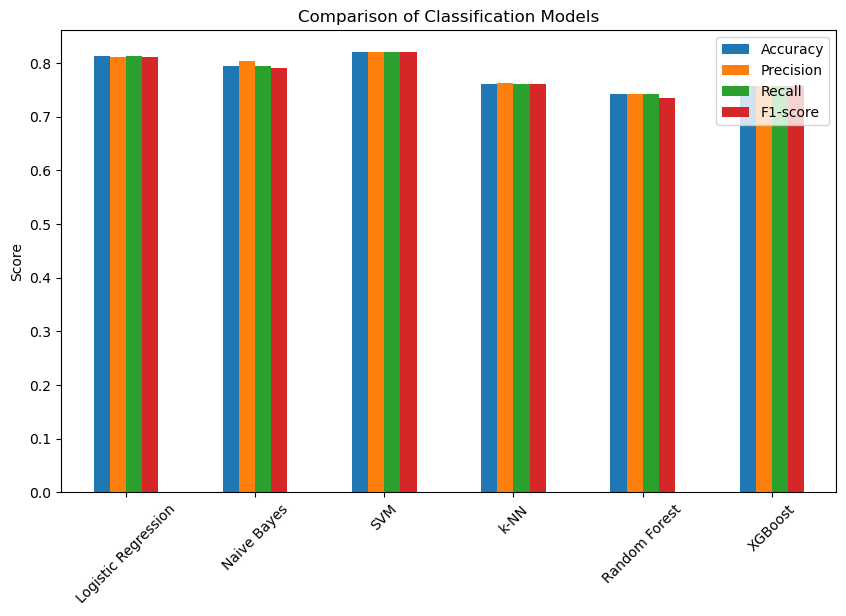

In [50]:

# Создание DataFrame с метриками
metrics_df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1-score"])
metrics_df.T.plot(kind='bar', figsize=(10, 6), title="Comparison of Classification Models")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.show()


На основании полученных данных можно сделать следующие выводы:

Лучший результат в целом показала модель SVM (F1-score = 0.82), обеспечивая баланс между точностью и полнотой.

Наихудший результат у k-NN (F1-score = 0.76), что свидетельствует о недостаточной обобщающей способности модели для данной задачи.

Наиболее стабильные результаты у Logistic Regression и Naive Bayes, хотя у Naive Bayes наблюдается снижение качества для некоторых категорий (например, "Общество").

Random Forest показал себя как средний вариант, уступая SVM и логистической регрессии, но превосходя k-NN.

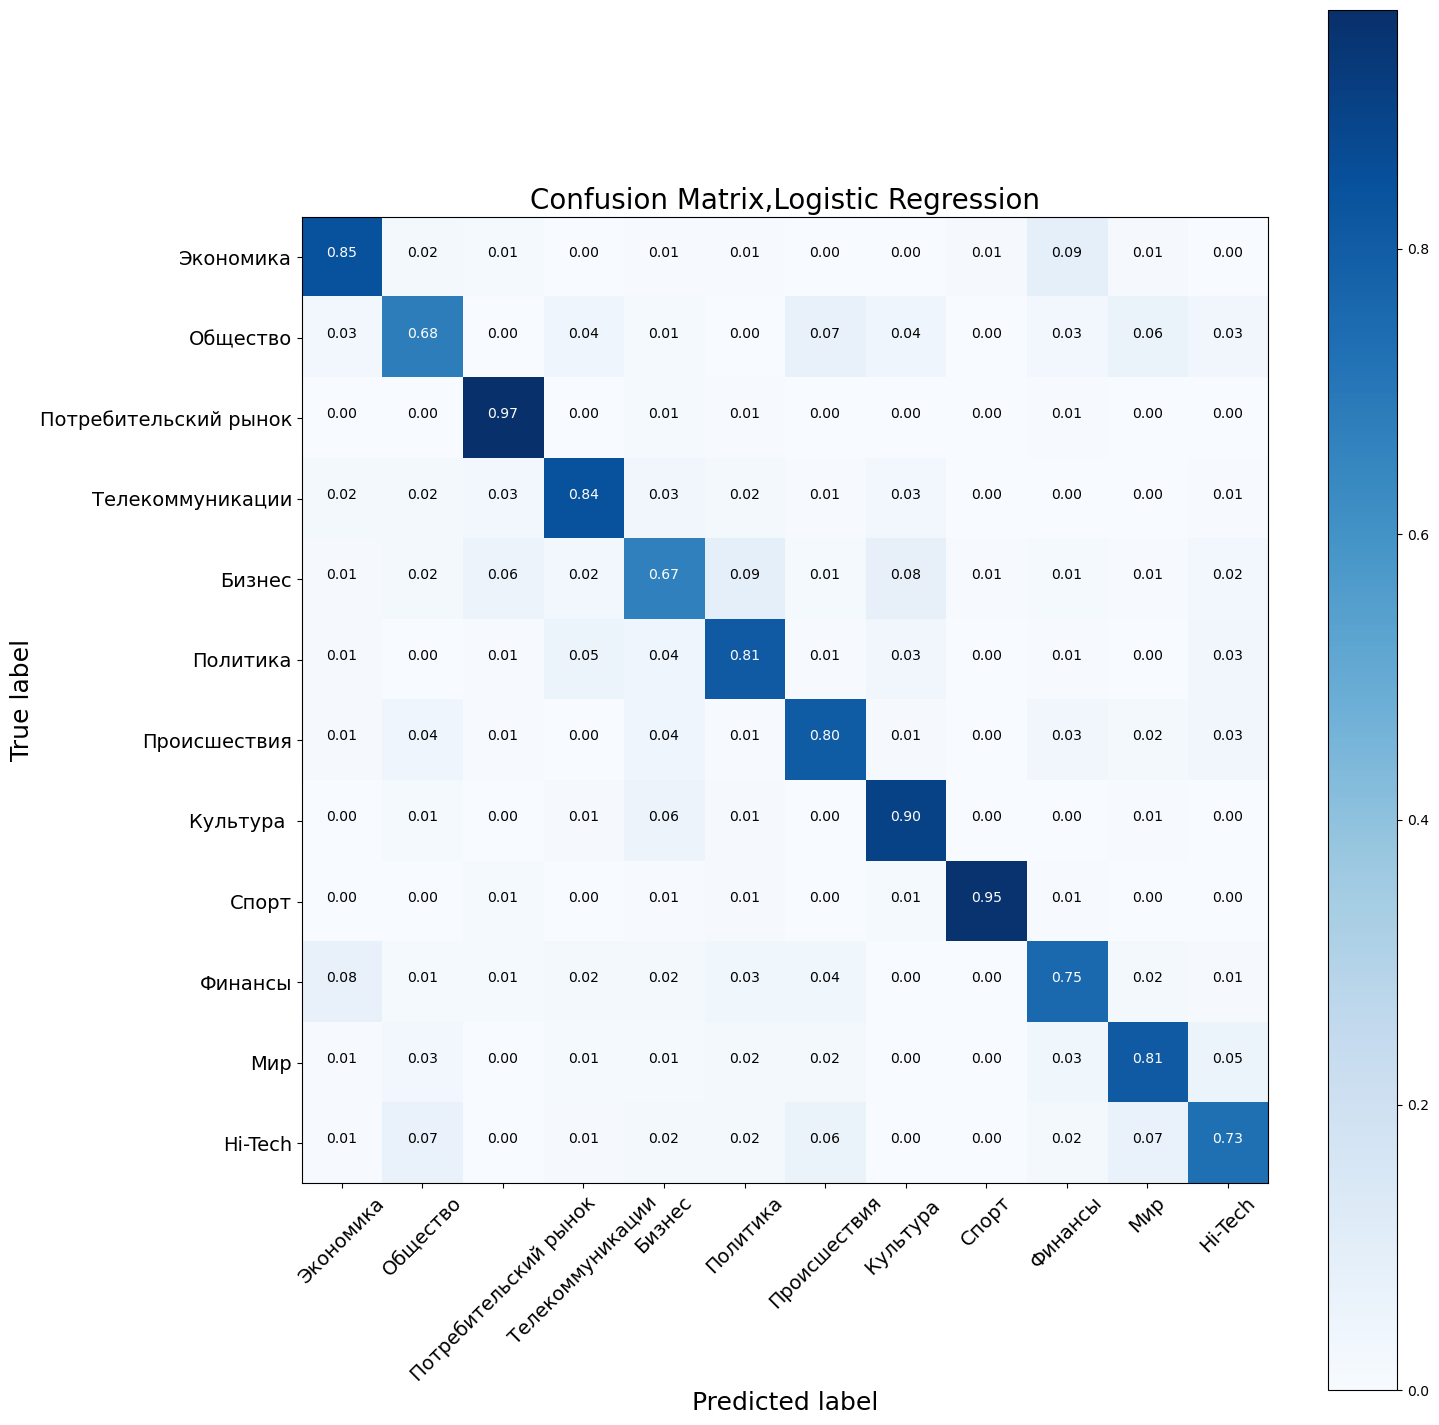

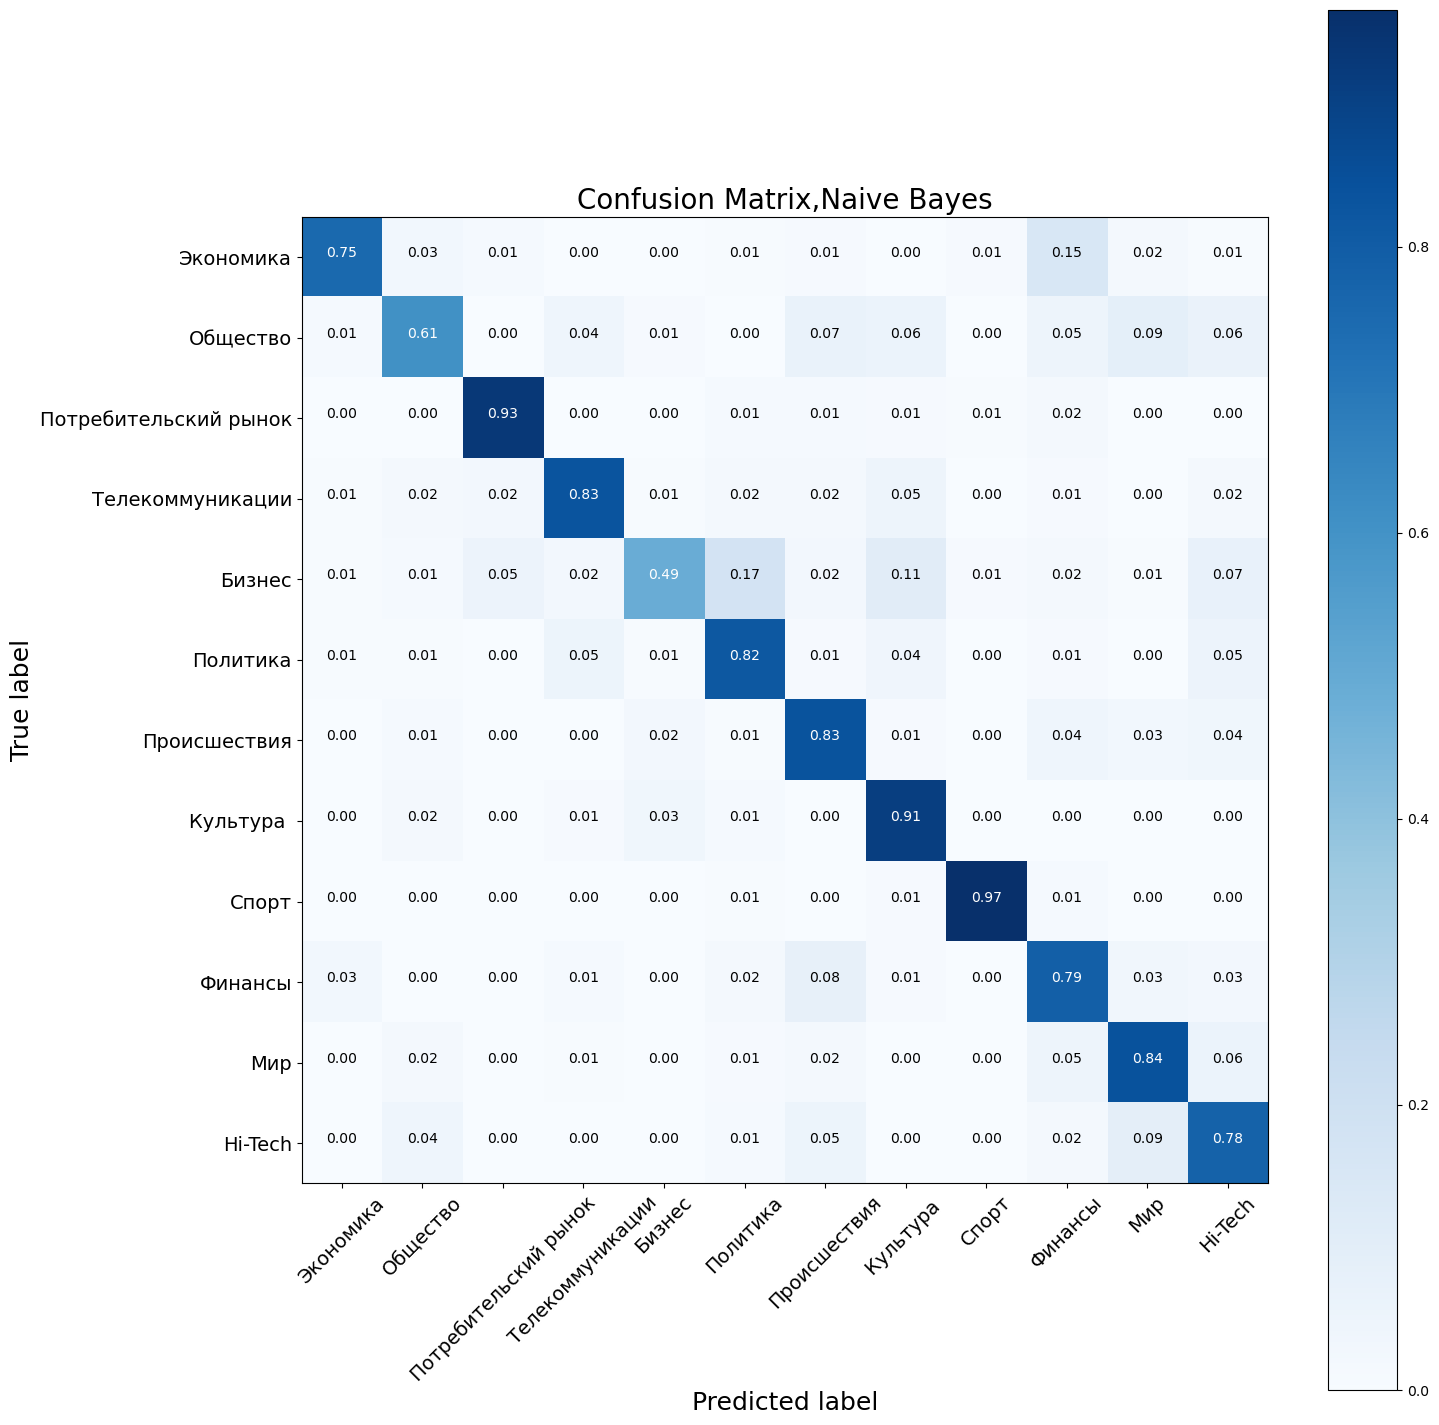

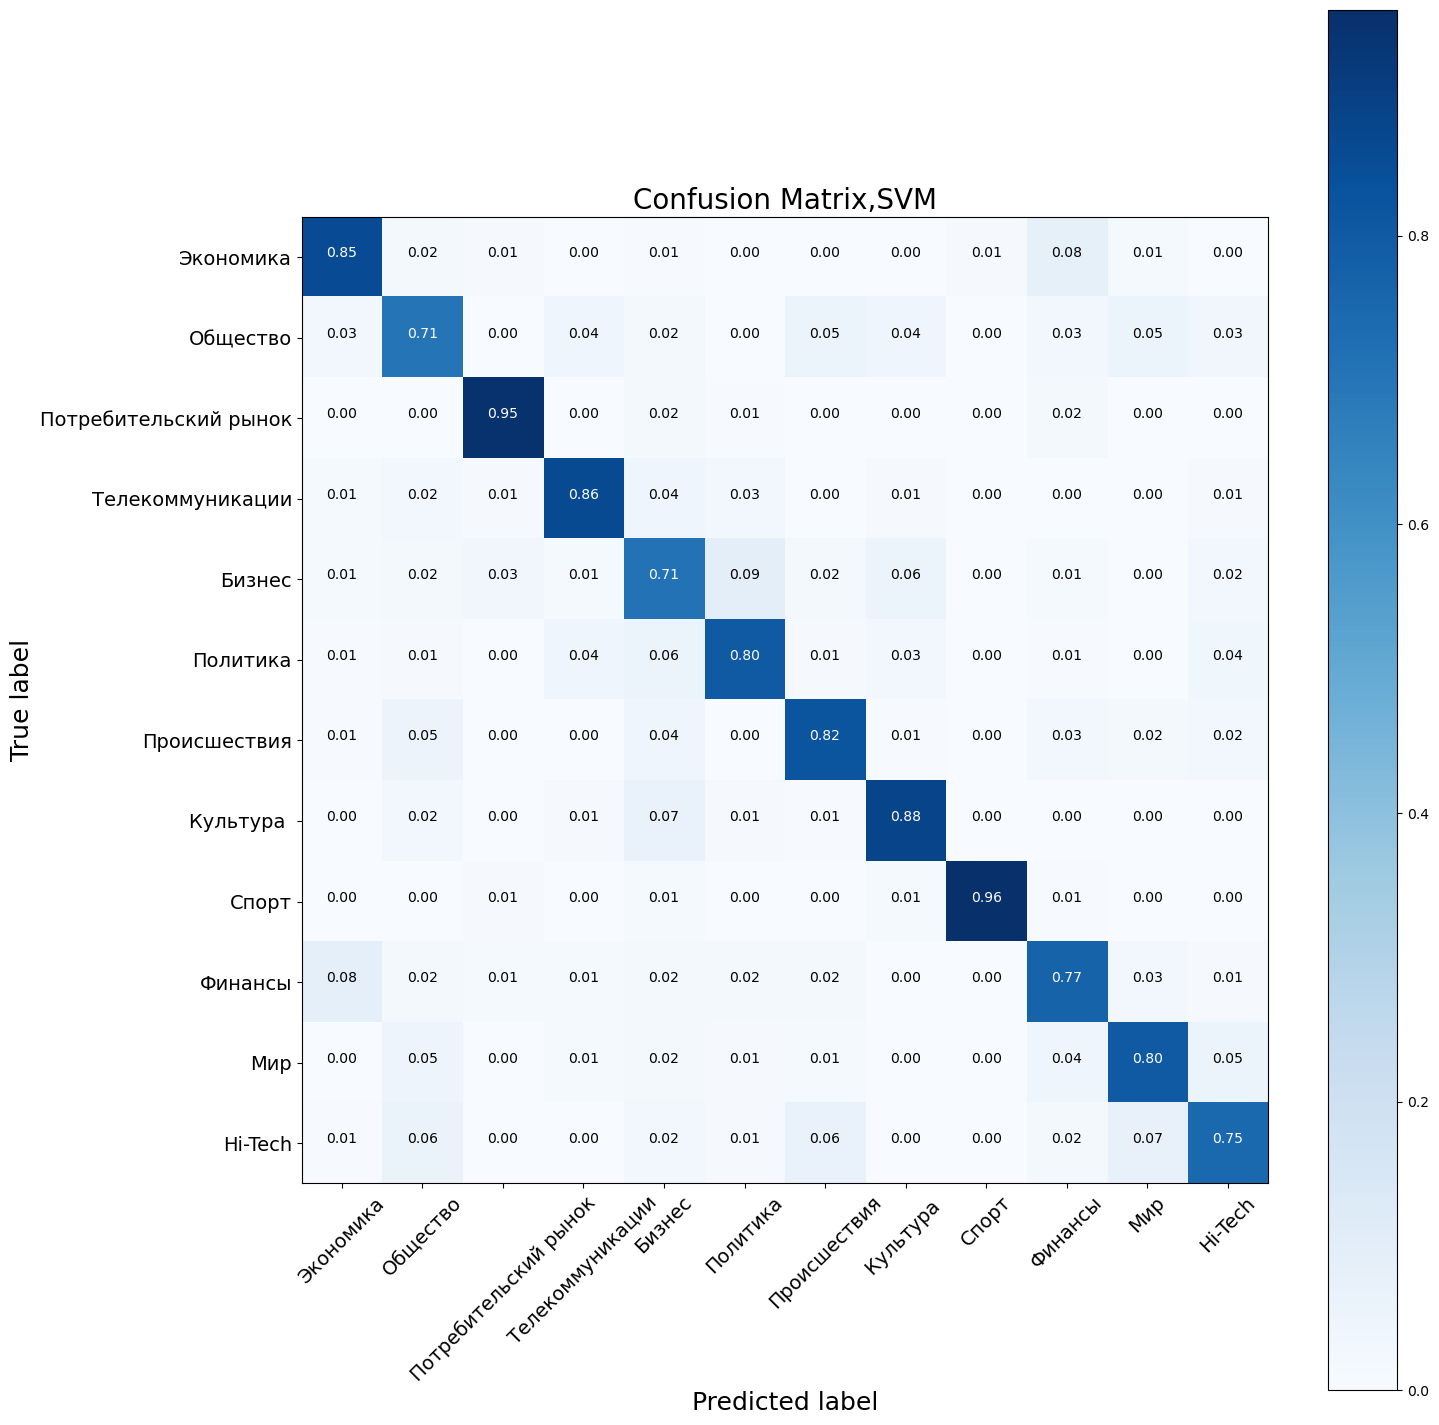

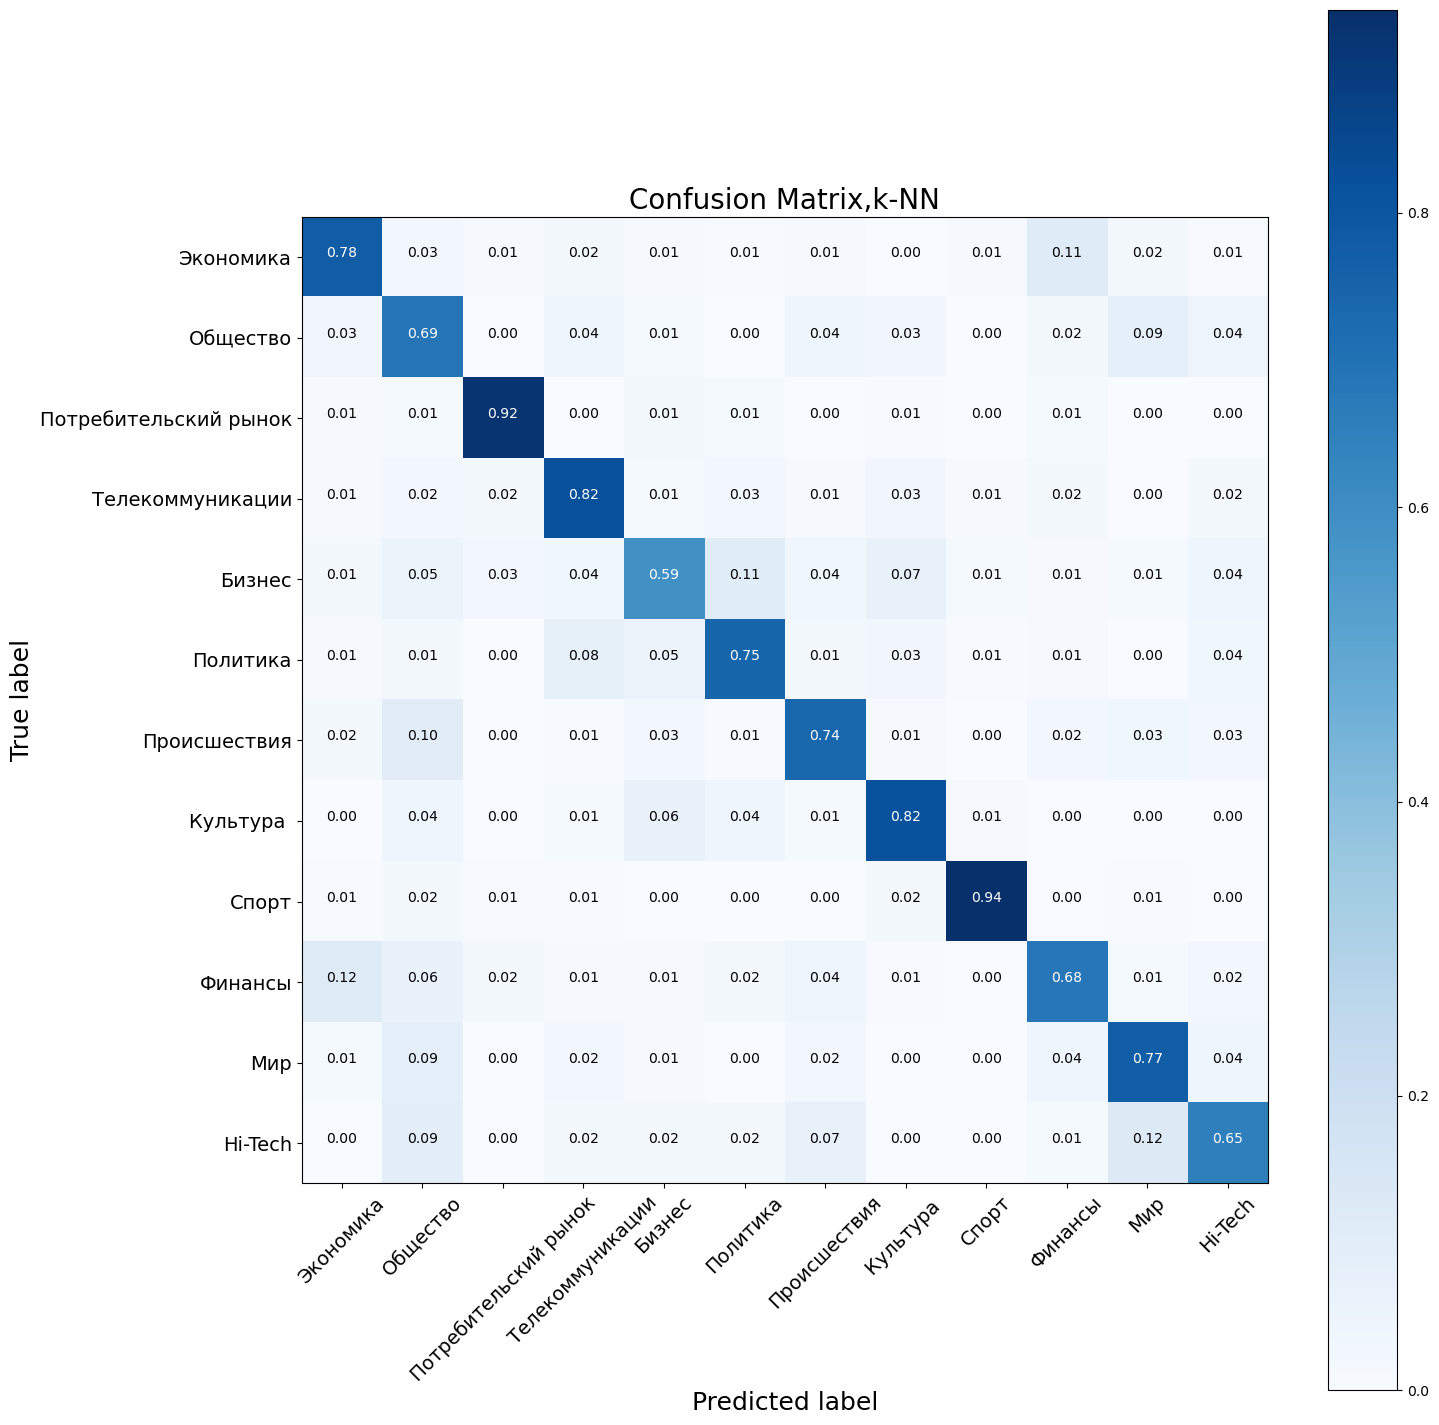

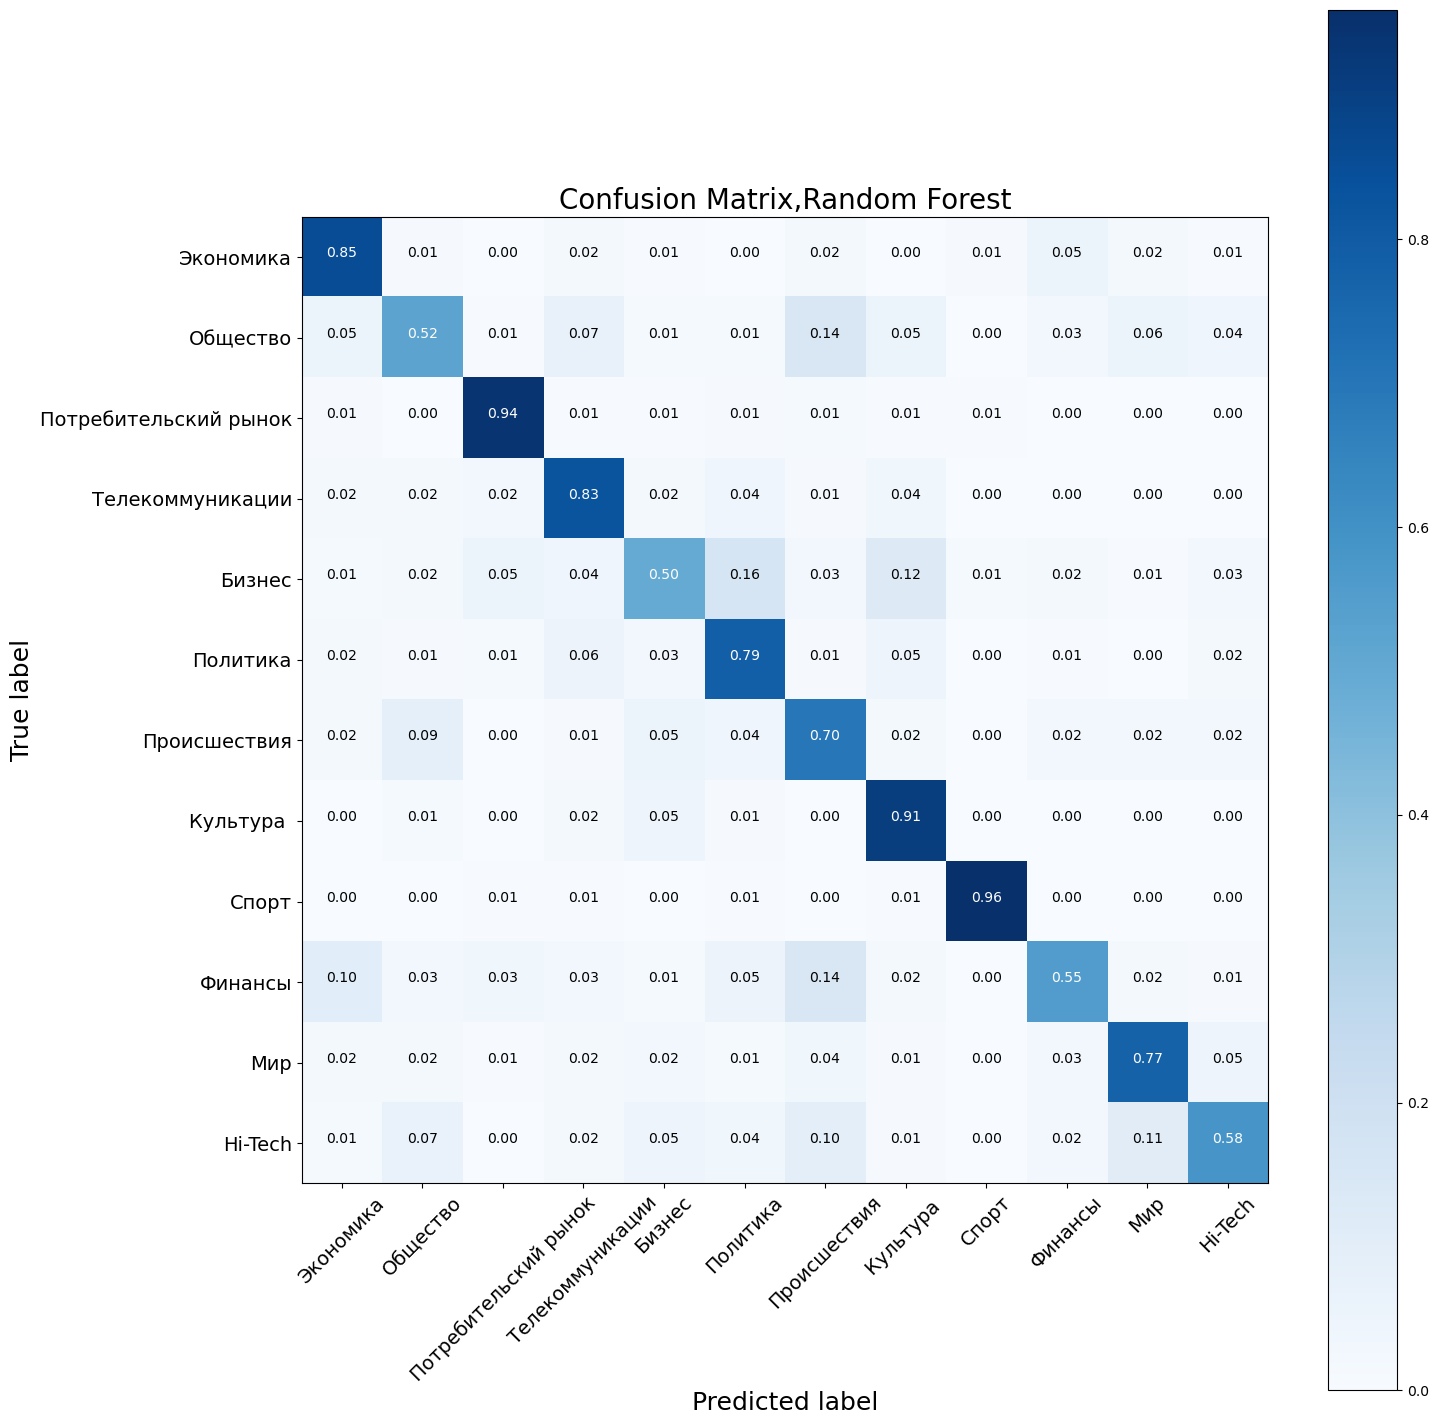

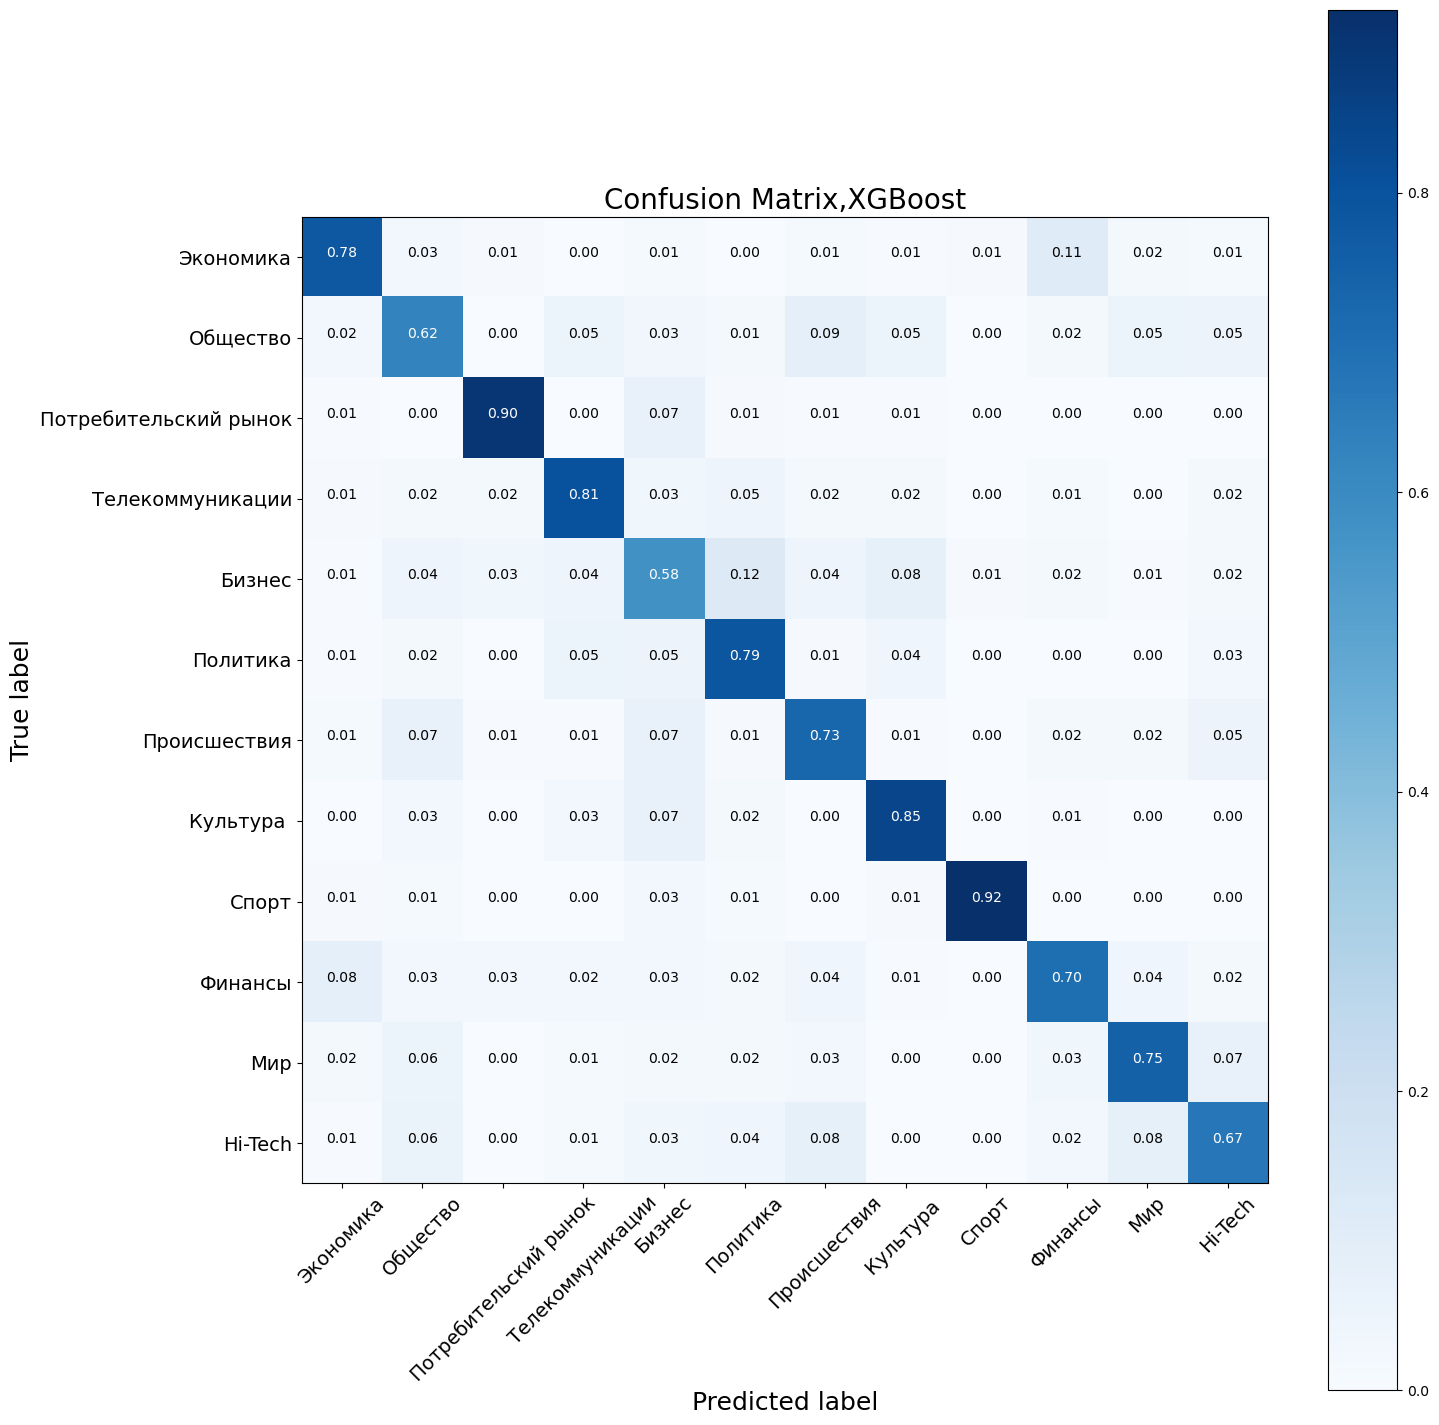

In [54]:

# Визуализация confusion matrix для каждой модели
for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, title='Confusion Matrix,' + name)
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], xticklabels=df['category'].unique(), yticklabels=df['category'].unique())
    # axes[i].set_title(f"{name} Confusion Matrix")
    # axes[i].set_xlabel("Predicted")
#     # axes[i].set_ylabel("Actual")
# plt.tight_layout()
# plt.show()


Логистическая регрессия 
- Хорошие результаты для категорий "Спорт" (95%), "Культура" (90%), "Экономика" (85%) и "Политика" (81%).
- Средняя точность у "Бизнеса" (67%).
- Ошибки распределены равномерно, но есть пересечения между "Обществом", "Финансами" и "Экономикой".

Наивный Байес 
- Самые точные классы: "Спорт" (97%), "Культура" (91%), "Экономика" (75%), "Политика" (82%).
- Самая слабая точность у "Бизнеса" (49%), что говорит о сложности выделения признаков.
- "Общество" и "Мир" также часто путаются.

SVM
- Самые точные категории: "Спорт" (96%), "Экономика" (85%), "Потребительский рынок" (95%) и "Политика" (80%).
- Лучше различает "Бизнес" (71%), чем Наивный Байес.
- Ошибки похожи на логистическую регрессию, но показатели немного выше.

k-NN
- Хорошие результаты для категорий "Спорт" (94%), "Культура" (82%), "Потребительский рынок" (92%) и "Политика" (75%).
- Средняя точность у "Бизнеса" (59%), "Финансов" (68%) и "Мира" (77%).
- Ошибки чаще всего возникают между "Экономикой", "Бизнесом" и "Финансами", а также между "Обществом" и "Миром".

Random Forest
- Самые точные классы: "Спорт" (96%), "Культура" (91%), "Экономика" (85%) и "Политика" (79%).
- Самая слабая точность у "Бизнеса" (50%), что говорит о сложности выделения признаков.
- "Общество" (52%) также имеет низкую точность, часто путается с "Миром" и "Происшествиями".

Gradient Boosting
- Самые точные категории: "Спорт" (92%), "Культура" (85%), "Потребительский рынок" (90%) и "Политика" (79%).
- "Бизнес" классифицируется лучше (58%), чем в k-NN и Random Forest.
- Ошибки распределены схоже с Random Forest, но бустинг немного лучше справляется с "Финансами" (70%) и "Hi-Tech" (67%).